In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

In [5]:
cuts_cat = Table.read('./Catalog/COSMOS/lsbg_COSMOS_after_cuts_JG.fits')

In [232]:
# Load Merian Image
merian_hdu = fits.open('/tigress/MERIAN/merian/cosmos_stack/c4d_210307_021334_osj_N708_wide.fits.fz')
merian_hdu[1].header['RADESYS']='FK5' 
w_img = wcs.WCS(merian_hdu[1].header)
img = merian_hdu[1].data

In [233]:
footprint = w_img.calc_footprint()

In [234]:
print('ZP=', merian_hdu[0].header['MAGZERO'])
skysub = merian_hdu[0].header['SKYSUB']
print('SKYSUB=', skysub)

img -= skysub

ZP= 30.677
SKYSUB= 337.0103


In [235]:
img *= 10**((27.0 - merian_hdu[0].header['MAGZERO']) / 2.5) # scale to ZP = 27.0

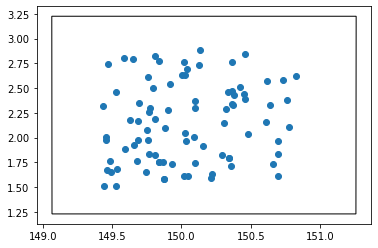

In [19]:
plt.scatter(cuts_cat['ra'], cuts_cat['dec'])
plt.gca().add_patch(Polygon(footprint, edgecolor='k', fill=False))

In [16]:
cuts_cat = cuts_cat[cuts_cat['SB_eff_avg'][:, 0] > 24.3]

In [21]:
## For visual inspection
cuts_cat[['viz-id', 
          'ra', 
          'dec']].write('/tigress/jiaxuanl/public_html/galary/catalogs/cosmos_udg_candidates.txt', 
                        format='ascii', overwrite=True)

In [236]:
from kuaizi.utils import img_cutout
import os
filt = 'N708'

In [237]:
for obj in cuts_cat:
    obj_id = obj['viz-id']
    
    x, y = w_img.wcs_world2pix(obj['ra'], obj['dec'], 0)
    
    if not os.path.isdir(f'./Cutout/cosmos_udg/'):
        os.makedirs(f'./Cutout/cosmos_udg/')

    img_cut, [cen_pos, dx, dy], img_cut_header = img_cutout(
        img,
        w_img, obj['ra'], obj['dec'], # subtract a global bkg
        size=[obj['radius'] * 2 * 60, obj['radius'] * 2 * 60],
        pixel_scale=0.27,
        save=False,)
    
    img_cut_header['RADESYS'] = 'FK5' 
    img_cut_header['CDELT1'] = img_cut_header['CD1_1']
    img_cut_header['CDELT2'] = img_cut_header['CD2_2']
    
    hdu1 = fits.HDUList([
        fits.PrimaryHDU(header=merian_hdu[0].header),  # header
        fits.ImageHDU(data=img_cut.data, header=img_cut_header,
                      name='IMAGE'),  # image
    ])
        

    fits_file = f'cosmos_{obj_id}_{filt}' + '.fits'
    fits_file = os.path.join(f'./Cutout/cosmos_udg/', fits_file)

    hdu1.writeto(fits_file, overwrite=True)

In [238]:
from kuaizi.mock import Data
import kuaizi.multicolorfits as mcf
import kuaizi
kuaizi.set_matplotlib(style='nature', usetex=False)

In [239]:
CUTOUT_DIR = '/tigress/jiaxuanl/Data/HSC/LSBG/Cutout/COSMOS'
MERIAN_DIR = '/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/cosmos_udg'

In [420]:
ind = 43216

obj = cuts_cat[cuts_cat['viz-id'] == ind][0]
cutout_size = 30 # arcsec

ref_filt = 'i'
dataset = {}

In [421]:
# Reference bandpass
filt = ref_filt

filedir = f'{MERIAN_DIR}/cosmos_{ind}_{filt}.fits' if filt == 'N708' else f'{CUTOUT_DIR}/cosmos_{ind}_{filt}.fits'
gal_img, gal_hdr = fits.getdata(filedir, header=True)
_, ref_hdr_crop = mcf.cropfits2D_coords(gal_img, 
                                        mcf.makesimpleheader(gal_hdr, radesys='FK5'), 
                                        [obj['ra'], obj['dec']], 
                                        cutout_size)

In [422]:
for filt in list('grizy') + ['N708']:
    filedir = f'{MERIAN_DIR}/cosmos_{ind}_{filt}.fits' if filt == 'N708' else f'{CUTOUT_DIR}/cosmos_{ind}_{filt}.fits'
    gal_img, gal_hdr = fits.getdata(filedir, header=True)
    gal_crop_img = mcf.reproject2D(gal_img, mcf.makesimpleheader(gal_hdr), ref_hdr_crop);
    dataset[filt] = Data(gal_crop_img, wcs=wcs.WCS(ref_hdr_crop))

In [430]:
color_dict = {'g': "#2e0af7", 
              'r': "#07f7eb", 
              'i': "#2beb05", 
              'z': "#f5a105", 
              'y': "#f54905",
              'N708': "#f01307"}

In [431]:
#Adjust the rescalefn, min_max_scale and gamma to get the best image
#rescalefn: log, linear, sqrt, asinh, squared, etc.
rescalefn = 'log'
#scaletype can be perc(entage) or abs(olute)
min_max_scale = [0.1, 99.99]
gamma = 4

greyRGBs = {}
for filt in list('grizy') + ['N708']:
    greyRGBs[filt] = mcf.greyRGBize_image(dataset[filt].images, 
                                          rescalefn=rescalefn, 
                                          scaletype='perc', 
                                          min_max=min_max_scale, 
                                          gamma=gamma, checkscale=False) 

In [432]:
gammacorr_color = gamma - 2

color_imgs = {}
for filt in list('grizy') + ['N708']:
    color_imgs[filt] = mcf.colorize_image(greyRGBs[filt], 
                                        color_dict[filt], 
                                        colorintype="hex", 
                                        gammacorr_color=gammacorr_color)

In [433]:
gal_merian = mcf.combine_multicolor(
    [color_imgs[filt] for filt in ['N708', 'y', 'z', 'i', 'r', 'g']], 
    gamma=gammacorr_color
)

gal_normal = mcf.combine_multicolor(
    [color_imgs[filt] for filt in ['y', 'z', 'i', 'r', 'g']], 
    gamma=gammacorr_color
)

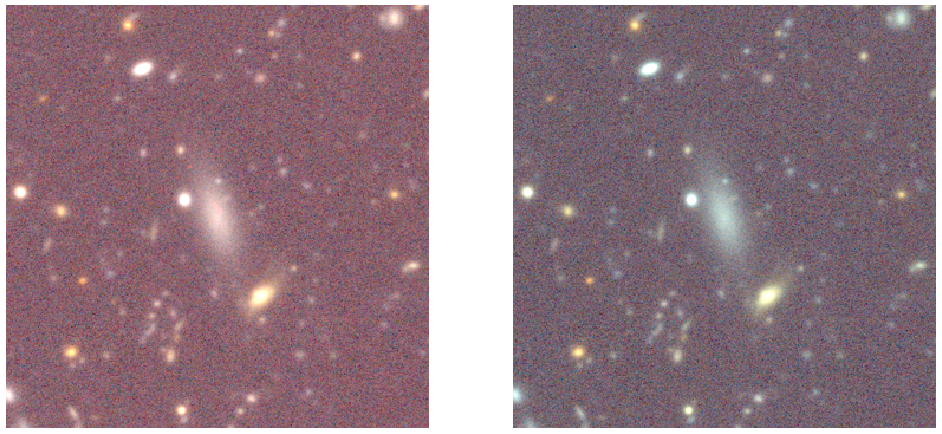

In [434]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(gal_merian)
ax1.set_axis_off()

ax2.imshow(gal_normal)
ax2.set_axis_off()